In [93]:
from google.cloud import bigquery
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as mtick
import matplotlib.patches as mpatches
from matplotlib import colormaps 
import seaborn as sns
import alluvial
from collections import Counter
import copy

In [2]:
client = bigquery.Client(project='subugoe-wag-closed')

In [3]:
s2ag_papers = 'subugoe-wag-closed.S2AG.papers'

In [4]:
sns.set_style('whitegrid')
plt.rc('font', family='Arial')
plt.rc('font', size=9) 
plt.rc('axes', titlesize=9) 
plt.rc('axes', labelsize=9) 
plt.rc('xtick', labelsize=9) 
plt.rc('ytick', labelsize=9) 
plt.rc('legend', fontsize=9)

## Abdeckung von DOIs

In [4]:
df_doi = client.query(f"""
                       SELECT COUNT(DISTINCT(externalids.DOI)) AS number_of_dois, 
                              COUNT(1) AS number_of_publications, 
                              EXTRACT (YEAR FROM publicationdate) AS year
                       FROM {s2ag_papers} 
                       GROUP BY year
                       ORDER BY year DESC
                       """).to_dataframe()

In [5]:
df_doi_2000 = df_doi[df_doi.year > 2000]

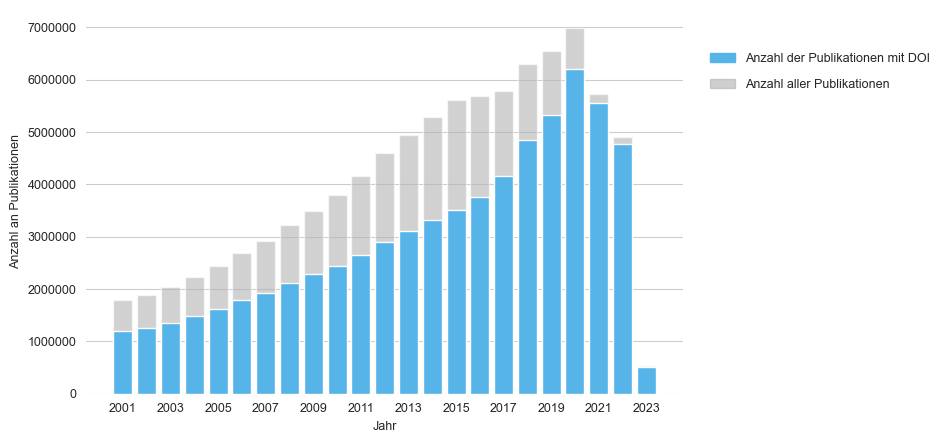

In [39]:
fig, ax = plt.subplots(figsize=(7,4.5))
plt.box(False)

sns.barplot(data=df_doi_2000, 
            x='year', 
            y='number_of_publications', 
            alpha=0.6,
            color='#b3b3b3a0',
            saturation=1,
            errorbar=None)

sns.barplot(data=df_doi_2000, 
            x='year', 
            y='number_of_dois', 
            alpha=1,
            color='#56B4E9',
            saturation=1,
            errorbar=None)

plt.locator_params(nbins=12, axis='x')
ax.yaxis.set_major_formatter(mtick.FormatStrFormatter('%.0f'))

ax.set(xlabel='Jahr', ylabel='Anzahl an Publikationen')

doi_patch = mpatches.Patch(color='#56B4E9', label='Anzahl der Publikationen mit DOI')
not_doi_patch = mpatches.Patch(color='#b3b3b3a0', label='Anzahl aller Publikationen')

lgd = fig.legend(handles=[doi_patch, not_doi_patch], frameon=False,
                 bbox_to_anchor=(1.35, 0.9), labelspacing=1.1)

plt.tight_layout()

plt.show()

## Abdeckung von Publikationstypen

In [9]:
df_types_single = client.query(f"""
                                SELECT type, COUNT(type) AS number_of_publications
                                FROM (
                                     SELECT type
                                     FROM {s2ag_papers}, UNNEST(publicationtypes) as type 
                                     )
                                GROUP BY type
                                """).to_dataframe()

In [10]:
df_types_single

,type,number_of_publications
0,Dataset,727
1,MetaAnalysis,103671
2,Book,274375
3,News,238177
4,Conference,3845648
5,LettersAndComments,1539430
6,ClinicalTrial,582157
7,Editorial,656743
8,JournalArticle,39583456
9,Study,2341438


In [11]:
df_types_agg = client.query(f"""
                             SELECT ARRAY_TO_STRING(publicationtypes, ",") AS types, 
                                    COUNT(publicationtypes) AS number_of_publications
                             FROM {s2ag_papers}
                             GROUP BY types
                             ORDER BY number_of_publications DESC
                             """).to_dataframe()

In [12]:
df_types_agg

,types,number_of_publications
0,,157488353
1,JournalArticle,28452480
2,Review,8790961
3,"Review,JournalArticle",2645627
4,Conference,2254022
...,...,...
615,"ClinicalTrial,JournalArticle,Study,MetaAnalysi...",1
616,"MetaAnalysis,JournalArticle,ClinicalTrial,Case...",1
617,"LettersAndComments,JournalArticle,ClinicalTria...",1
618,"JournalArticle,ClinicalTrial,CaseReport,Confer...",1


In [17]:
df_types_agg['types'] = df_types_agg['types'].apply(lambda x: x.split(','))

In [85]:
types_dict_count = Counter(
    Dataset=0,
    MetaAnalysis=0,
    Book=0,
    News=0,
    Conference=0,
    LettersAndComments=0,
    ClinicalTrial=0,
    Editorial=0,
    JournalArticle=0,
    Study=0,
    CaseReport=0,
    Review=0
)

In [86]:
types_dict = dict(
    Dataset=copy.copy(types_dict_count),
    MetaAnalysis=copy.copy(types_dict_count),
    Book=copy.copy(types_dict_count),
    News=copy.copy(types_dict_count),
    Conference=copy.copy(types_dict_count),
    LettersAndComments=copy.copy(types_dict_count),
    ClinicalTrial=copy.copy(types_dict_count),
    Editorial=copy.copy(types_dict_count),
    JournalArticle=copy.copy(types_dict_count),
    Study=copy.copy(types_dict_count),
    CaseReport=copy.copy(types_dict_count),
    Review=copy.copy(types_dict_count)
    
)

In [87]:
def count_combinations(type_combination: list, number_of_publications: int):
    for t in type_combination:
        if t == '':
            continue
        d = types_dict[t]
        for t_count in d:
            for t2 in type_combination:
                if t2 == t_count:
                    d[t_count] += number_of_publications

In [88]:
for row in df_types_agg.to_dict('records'):
    count_combinations(row['types'], row['number_of_publications'])

In [90]:
types_dict['Dataset '] = types_dict.pop('Dataset')
types_dict['MetaAnalysis '] = types_dict.pop('MetaAnalysis')
types_dict['Book '] = types_dict.pop('Book')
types_dict['News '] = types_dict.pop('News')
types_dict['Conference '] = types_dict.pop('Conference')
types_dict['LettersAndComments '] = types_dict.pop('LettersAndComments')
types_dict['ClinicalTrial '] = types_dict.pop('ClinicalTrial')
types_dict['Editorial '] = types_dict.pop('Editorial')
types_dict['JournalArticle '] = types_dict.pop('JournalArticle')
types_dict['Study '] = types_dict.pop('Study')
types_dict['CaseReport '] = types_dict.pop('CaseReport')
types_dict['Review '] = types_dict.pop('Review')

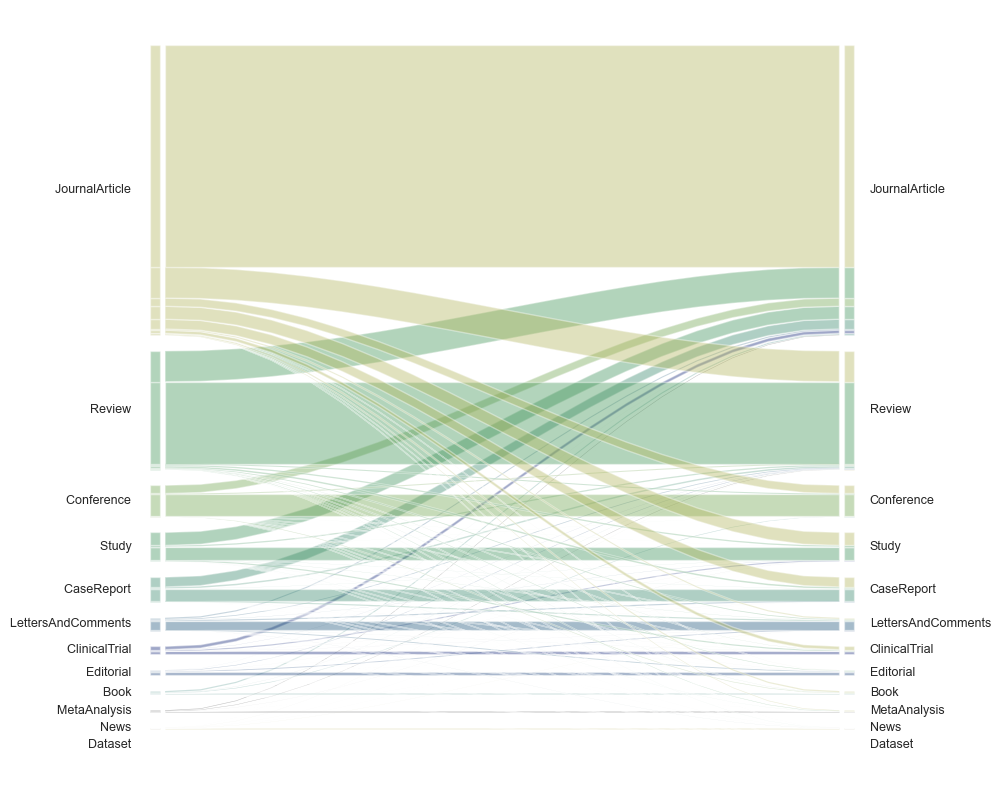

In [102]:
cmap = colormaps['gist_earth']

ax = alluvial.plot(types_dict, alpha=0.4, cmap=cmap, fontname='Arial')
fig = ax.get_figure()
fig.set_size_inches(10,10)
plt.show()